# Welcome to the CloudtoStreet Machine Learning Challenge

Modified version of a challenge provided by Philip Popien, at Cloud to Street.
Helper functions for setup and visualization are due to him. The rest are due to me.

In [1]:
# these are the packages we need for exploration
import os
import glob
import matplotlib.pyplot as plt
import tifffile
import numpy as np

from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon
from rasterio.features import shapes
from descartes import PolygonPatch

In [2]:
#BH: packages I brought in myself

import pandas as pd
import tensorflow as tf
import json
import tqdm
from functools import partial

In [3]:
#BH: Some known constants

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMAGE_SIZE = IMAGE_HEIGHT * IMAGE_WIDTH

# Setup

We will use our [Sen1Floods11](https://github.com/cloudtostreet/Sen1Floods11) dataset. We will create a local folder `c2s_data/v1.1/data/flood_events/HandLabeled` and download the handlabeled training data (Sentinel-1 512x512 chips, mask labels) there.

In [4]:
# Set True the first time running this notebook.

if False:
    os.makedirs("c2s_data/v1.1/data/flood_events/HandLabeled", exist_ok=True)

    !pip install gsutil
    !gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled c2s_data/v1.1/data/flood_events/HandLabeled

There are some faulty labels we will remove here.

In [5]:
def remove_faulty(img_folder="c2s_data/v1.1/data/flood_events/HandLabeled/S1Hand", 
                  label_folder="c2s_data/v1.1/data/flood_events/HandLabeled/LabelHand"):
    for uid in [
        'Ghana_141910',
        'Ghana_866994',
        'Mekong_1111068',
        'Pakistan_35915',
        'Pakistan_94095',
        'Paraguay_34417',
        'Paraguay_581976',
        'Spain_6095801'
    ]:
        
        faulty_img = f"{img_folder}/{uid}_S1Hand.tif"
        if os.path.exists(faulty_img):
            print('removing: ', faulty_img)
            os.remove(faulty_img)

        faulty_label = f"{label_folder}/{uid}_LabelHand.tif"
        if os.path.exists(faulty_label):
            print('removing: ', faulty_label)
            os.remove(faulty_label)

remove_faulty()

## Helper functions

In [6]:
def get_patchcollection_from_label(label, label_value=1, alpha=1, color="cyan"):
    """Turns a (H,W) mask into a PatchCollection of polygons"""
    polygons, colors = [], []
    for geom in shapes((label == label_value).astype(np.uint8), mask=(label == label_value).astype(np.uint8),
                       connectivity=4):
        poly = Polygon(geom[0]['coordinates'][0], holes=geom[0]['coordinates'][1:])
        polygons.append(PolygonPatch(poly.buffer(0)))
        colors.append(color)
    return PatchCollection(polygons, facecolor=colors, linewidths=0, alpha=alpha)

def visualize_s1_img(path):
    """Opens a Sentinel 1 image and returns a scaled RFCC false color composite image for visualization."""
    s1_img = tifffile.imread(path)
    if s1_img.shape[0] < 15: s1_img = np.transpose(s1_img, (1, 2, 0))
    if s1_img.shape[-1] == 3: s1_img = s1_img[:, :, :2]
    img = np.zeros((s1_img.shape[0], s1_img.shape[1], 3), dtype=np.float32)
    img[:, :, :2] = s1_img
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]
    return scale_S1_S2_img(img)

def scale_S1_S2_img(matrix):
    """Returns a scaled (H,W,D) image which is more easily visually inspectable. Image is linearly scaled between
    min and max_value of by channel"""
    w, h, d = matrix.shape
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    matrix = np.reshape(matrix, [w * h, d]).astype(np.float32)
    matrix = (matrix - min_values[None, :]) / (max_values[None, :] - min_values[None, :])
    matrix = np.reshape(matrix, [w, h, d])

    matrix = matrix.clip(0, 1)
    return matrix

# Part 1: Practical Deep Learning

## Exploration and Splitting

In the folder "S1Hand" we have 438 512x512 Sentinel-1 images from 11 countries. The folder "LabelHand" contains the water/no data masks for these images. 

Our goal is to have a model that achieves high mean Intersection over Union over all countries. 

__What I did__
- First I did a bit of data cleanup: I threw out some images where less that 20 percent of the pixels had a ground truth label.
- I created a 80/10/10 train/validation/test split for each country. There is relatively little data so I reserved most of it for training.
- As a quality check on these splits, I visualized the mean per-image water content, and the mean per-image percent of unknown pixels. These graphs are below.

In [7]:
# Countries we have data for
countries_present = sorted(list(set([k.split("/")[-1].split("_")[0] for k in glob.glob("c2s_data/v1.1/data/flood_events/HandLabeled/S1Hand/*.tif")])))
print(countries_present)

['Bolivia', 'Ghana', 'India', 'Mekong', 'Nigeria', 'Pakistan', 'Paraguay', 'Somalia', 'Spain', 'Sri-Lanka', 'USA']


In [8]:
S1_imgs = sorted(glob.glob("c2s_data/v1.1/data/flood_events/HandLabeled/S1Hand/*.tif"))
labels_GT = sorted(glob.glob("c2s_data/v1.1/data/flood_events/HandLabeled/LabelHand/*.tif"))
print(len(S1_imgs), len(labels_GT))

438 438


For Visualization we are using a false color composite of the two Sentinel-1 channels and some color stretching. 

The label masks are 1 for water pixels (shown in cyan) and -1 for no data, e.g. clouds on the Sentinel-2 image we labeled the data on (shown in magenta).

Paraguay_198534_S1Hand.png


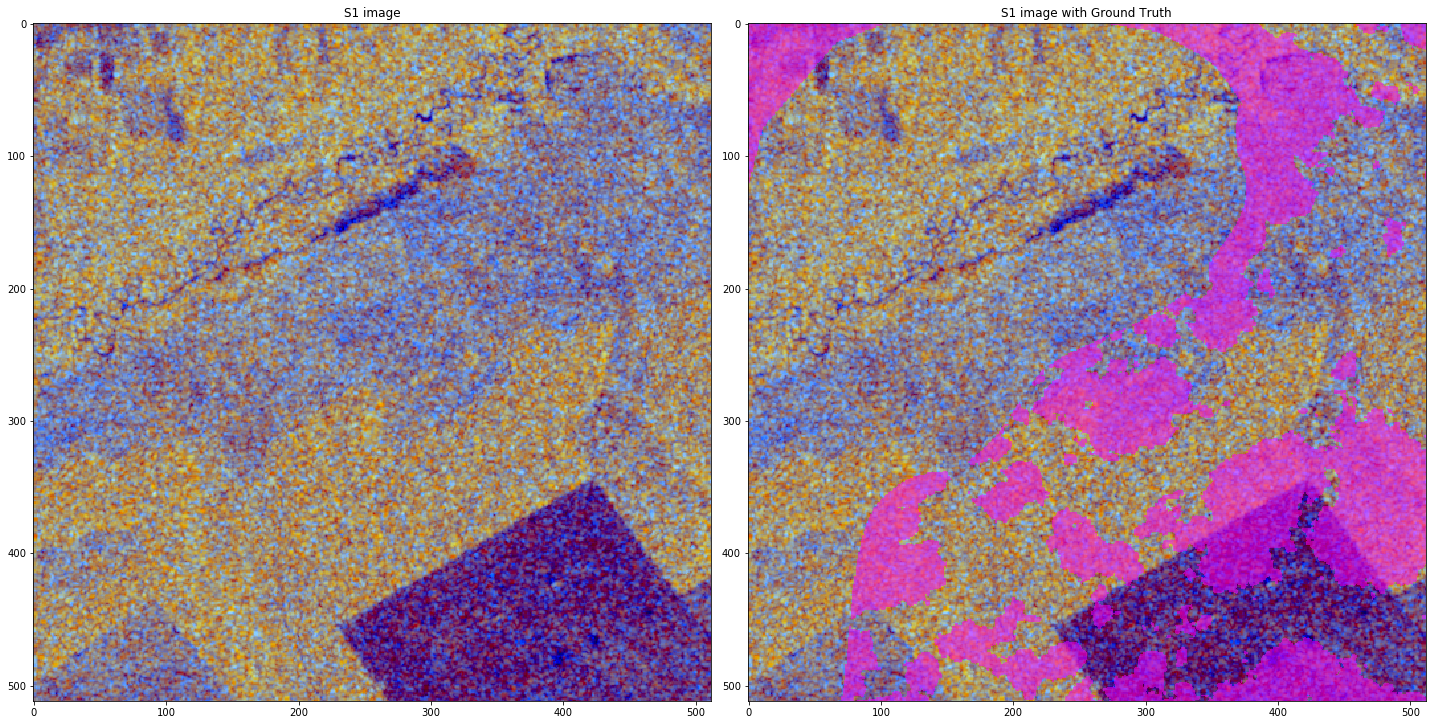

USA_115033_S1Hand.png


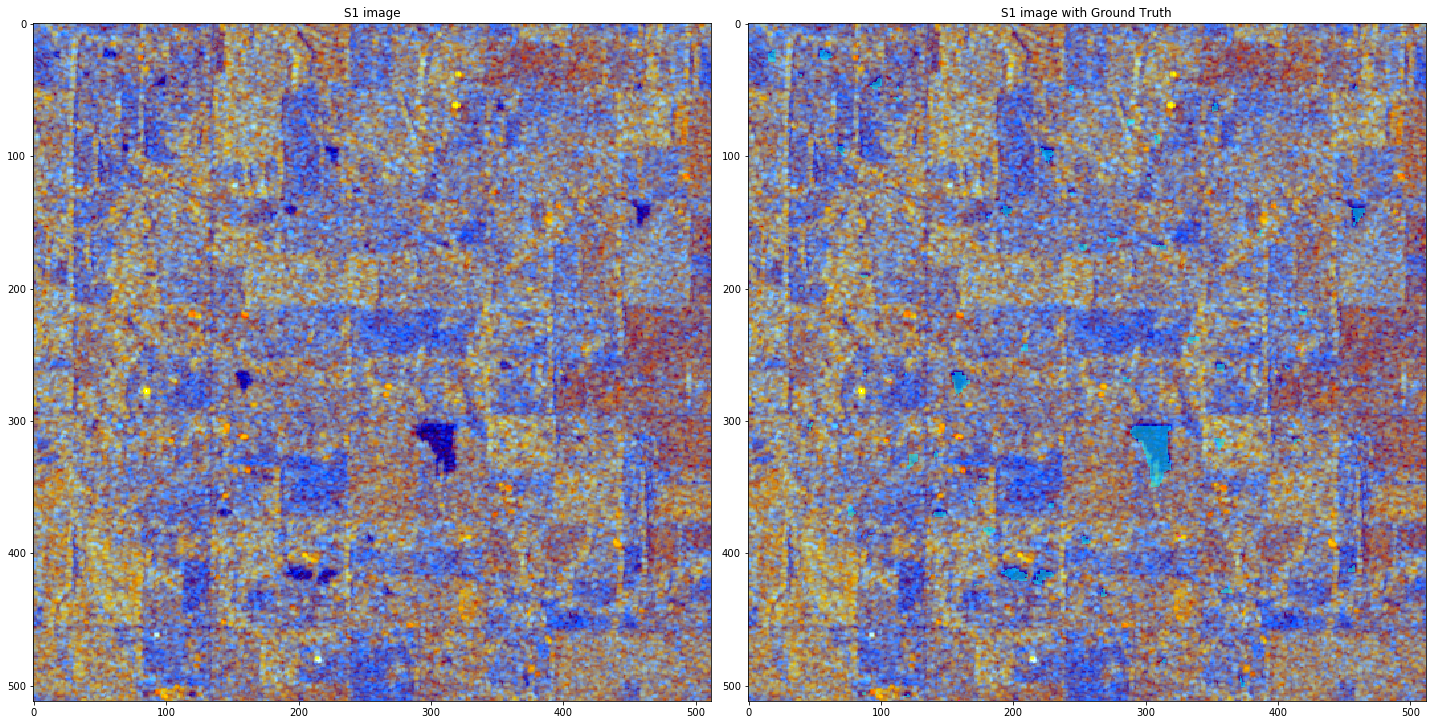

In [9]:
# plot random tiles
# S1 image on the left, and the S1 image with the hand-labels overlain on the right.
show_how_many = 2
color = "cyan"
no_data_color = "magenta"
alpha = 0.5
for k in range(show_how_many):
    rand_int = np.random.randint(len(S1_imgs))
    filename = S1_imgs[rand_int].split("/")[-1].split(".")[0] + ".png"
    f, axarr = plt.subplots(1, 2, figsize=(20, 10))
    print(filename)
    img = visualize_s1_img(S1_imgs[rand_int])
    axarr[0].imshow(img)
    axarr[0].set_title("S1 image")
    axarr[1].imshow(img)
    axarr[1].set_title("S1 image with Ground Truth")
         
    label = tifffile.imread(labels_GT[rand_int])
    p = get_patchcollection_from_label(label, alpha=alpha, color=color)
    axarr[1].add_collection(p)
    p = get_patchcollection_from_label(label, -1, alpha=alpha, color=no_data_color)
    axarr[1].add_collection(p)
    
    plt.tight_layout()
    plt.show()

Generate a summary dataframe:

In [10]:
perc_unknown_list = []
perc_water_known_list = []
perc_dry_known_list = []
country_list = []
asset_id_list = []
label_fp_list = []
image_fp_list = []

for i, filepath in enumerate(labels_GT):
    label = tifffile.imread(filepath)
    image_fp = S1_imgs[i]
    image = tifffile.imread(image_fp)
    
    asset_id = filepath.split("/")[-1].replace("_LabelHand.tif", "")
    country = filepath.split("/")[-1].split("_")[0]
    
    num_unknown_pixels = len(label[label == -1])
    num_dry_pixels = len(label[label == 0])
    num_water_pixels = len(label[label == 1])
    perc_unknown = num_unknown_pixels / IMAGE_SIZE
    try:
        perc_water_known = num_water_pixels / (IMAGE_SIZE - num_unknown_pixels)
        perc_dry_known = num_dry_pixels / (IMAGE_SIZE - num_unknown_pixels)
    except:
        perc_water_known = 0
        perc_dry_known = 0
        
    perc_unknown_list.append(perc_unknown)
    perc_water_known_list.append(perc_water_known)
    perc_dry_known_list.append(perc_dry_known)
    country_list.append(country)
    asset_id_list.append(asset_id)
    label_fp_list.append(filepath)
    image_fp_list.append(image_fp)
    
summary_df = pd.DataFrame.from_dict({'perc_unknown' : perc_unknown_list,
                                     'perc_water_known' : perc_water_known_list,
                                     'perc_dry_known' : perc_dry_known_list,
                                     'country' : country_list,
                                     'asset_id' : asset_id_list,
                                     'label_fp' : label_fp_list,
                                     'image_fp' : image_fp_list})

summary_df.set_index('asset_id', inplace = True)
summary_df

perc_unknown  perc_water_known  perc_dry_known  country  \
asset_id                                                                  
Bolivia_103757      0.664013          0.401490        0.598510  Bolivia   
Bolivia_129334      0.092812          0.658679        0.341321  Bolivia   
Bolivia_195474      0.003086          0.005935        0.994065  Bolivia   
Bolivia_23014       0.200901          0.037140        0.962860  Bolivia   
Bolivia_233925      0.425747          0.000007        0.999993  Bolivia   
...                      ...               ...             ...      ...   
USA_908474          0.000278          0.007044        0.992956      USA   
USA_933610          0.000446          0.014590        0.985410      USA   
USA_955053          0.000015          0.136713        0.863287      USA   
USA_986268          0.000080          0.034686        0.965314      USA   
USA_994009          0.000481          0.007240        0.992760      USA   

                                                         label_fp  \
asset_id                                                            
Bolivia_103757  c2s_data/v1.1/data/flood_events/HandLabeled/La...   
Bolivia_129334  c2s_data/v1.1/data/flood_events/HandLabeled/La...   
Bolivia_195474  c2s_data/v1.1/data/flood_events/HandLabeled/La...   
Bolivia_23014   c2s_data/v1.1/data/flood_events/HandLabeled/La...   
Bolivia_233925  c2s_data/v1.1/data/flood_events/HandLabeled/La...   
...                                                           ...   
USA_908474      c2s_data/v1.1/data/flood_events/HandLabeled/La...   
USA_933610      c2s_data/v1.1/data/flood_events/HandLabeled/La...   
USA_955053      c2s_data/v1.1/data/flood_events/HandLabeled/La...   
USA_986268      c2s_data/v1.1/data/flood_events/HandLabeled/La...   
USA_994009      c2s_data/v1.1/data/flood_events/HandLabeled/La...   

                                                         image_fp  
asset_id                                                           
Bolivia_103757  c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
Bolivia_129334  c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
Bolivia_195474  c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
Bolivia_23014   c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
Bolivia_233925  c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
...                                                           ...  
USA_908474      c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
USA_933610      c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
USA_955053      c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
USA_986268      c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
USA_994009      c2s_data/v1.1/data/flood_events/HandLabeled/S1...  

[438 rows x 6 columns]

Some data cleanup: take out images with low label quality

In [11]:
quality_threshold = .8
print("removing %d images because of low label quality" % len(summary_df[summary_df['perc_unknown'] >= quality_threshold]))
summary_df = summary_df[summary_df['perc_unknown'] < quality_threshold]

removing 15 images because of low label quality


Form dataset splits, on a per-country level. Here I'm assuming images aren't overlapping, so there is no problem with having one country appear in all three splits.

In [12]:
train_perc = .8
val_perc = .1
test_perc = 1 - train_perc - val_perc

asset_splits = {'train' : [], 'val' : [], 'test' : []}

seed = 43
rng = np.random.default_rng(seed = seed)

for country in countries_present:
    country_assets = summary_df[summary_df['country'] == country].index
    country_assets = list(rng.permutation(country_assets))

    total_country_assets = len(country_assets)
    num_val_assets = np.int(np.ceil(total_country_assets * val_perc))
    num_test_assets = np.int(np.ceil(total_country_assets * test_perc))

    asset_splits['val'].extend(country_assets[:num_val_assets])
    asset_splits['test'].extend(country_assets[num_val_assets: num_test_assets + num_val_assets])
    asset_splits['train'].extend(country_assets[num_test_assets + num_val_assets:])

splits_dict = {asset_id : key for key in asset_splits for asset_id in asset_splits[key]}

In [13]:
# These are the final dataframes we'll use

summary_df = summary_df.merge(pd.DataFrame.from_dict(splits_dict, orient = 'index', columns = ['split']),
                              left_index = True, right_index = True)

train_df = summary_df[summary_df['split'] == 'train']
val_df = summary_df[summary_df['split'] == 'val']
test_df = summary_df[summary_df['split'] == 'test']

Sanity check: Visualize the splits

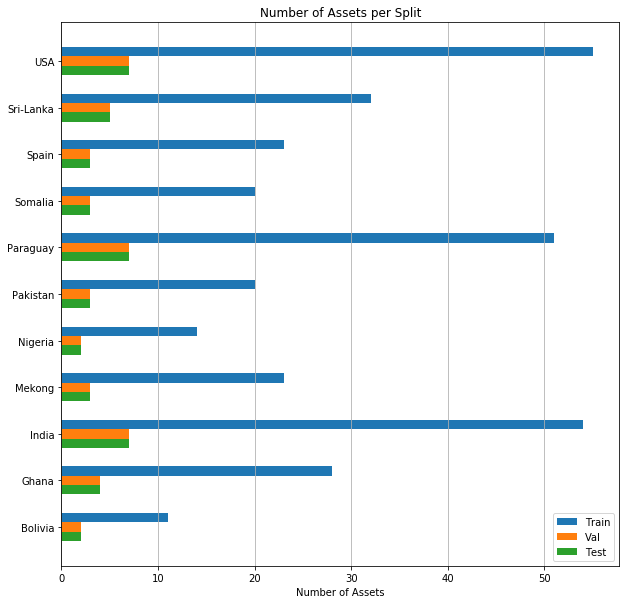

In [14]:
train_counts = {country : len(train_df[train_df['country'] == country]) for country in countries_present}
val_counts = {country : len(val_df[val_df['country'] == country]) for country in countries_present}
test_counts = {country : len(test_df[test_df['country'] == country]) for country in countries_present}

y_pos = np.arange(len(countries_present))
width = 0.2

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
rects1 = ax.barh(y_pos + width, [train_counts[country] for country in countries_present], width, label='Train') # train "first"
rects2 = ax.barh(y_pos, [val_counts[country] for country in countries_present], width, label='Val') # val "middle"
rects3 = ax.barh(y_pos - width, [test_counts[country] for country in countries_present], width, label='Test')   # test "below"

ax.set_xlabel('Number of Assets')
ax.set_title('Number of Assets per Split')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries_present)

ax.legend()
ax.grid(axis='x')
fig.show()

Quality Check: Visualize some summary statistics. These are computed for each image individually, then averaged across all the images from a country

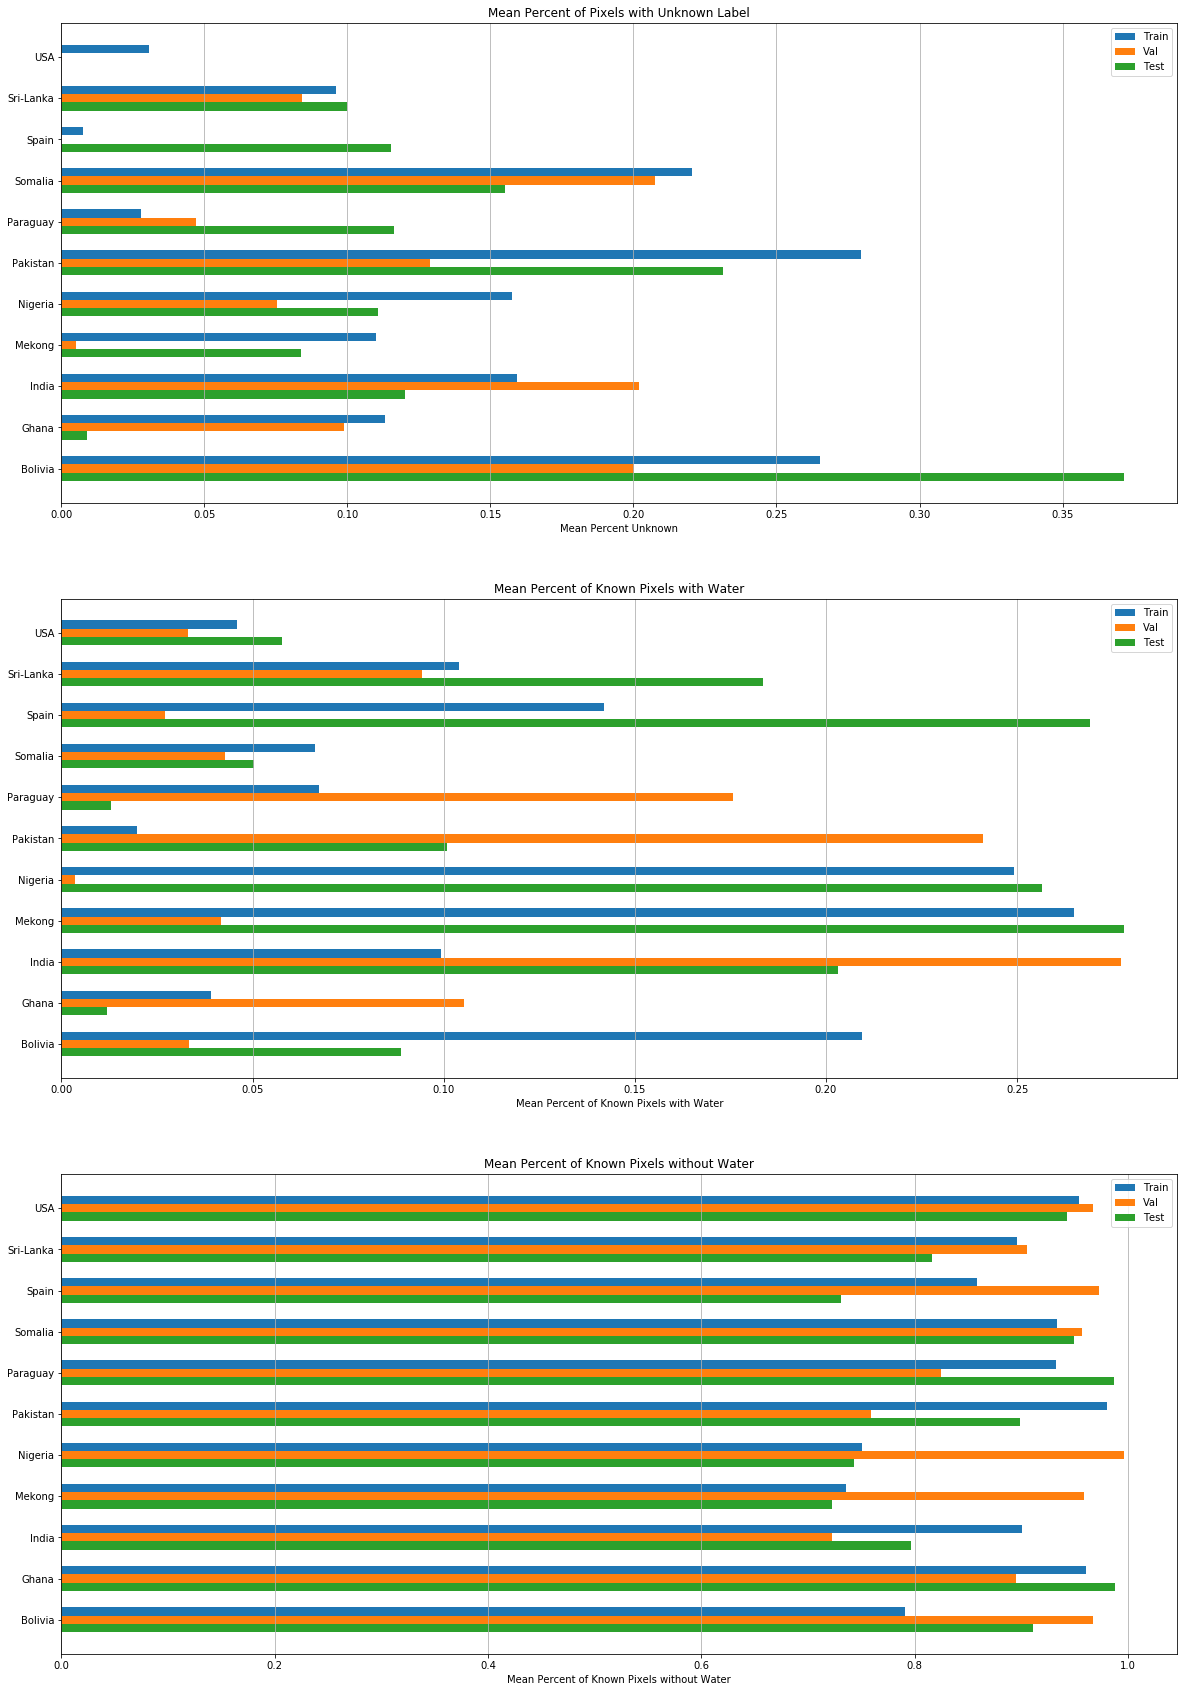

In [15]:
y_pos = np.arange(len(countries_present))
width = 0.2

fig = plt.figure(figsize=(20, 30))

## Visualize percent unknown

ax = fig.add_subplot(3,1,1)
rects1 = ax.barh(y_pos + width, [train_df[train_df['country'] == country].mean()['perc_unknown'] for country in countries_present], width, label='Train') # train "first"
rects2 = ax.barh(y_pos, [val_df[val_df['country'] == country].mean()['perc_unknown'] for country in countries_present], width, label='Val') # val "middle"
rects3 = ax.barh(y_pos - width, [test_df[test_df['country'] == country].mean()['perc_unknown'] for country in countries_present], width, label='Test')   # test "below"

ax.set_xlabel('Mean Percent Unknown')
ax.set_title('Mean Percent of Pixels with Unknown Label')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries_present)

ax.legend()
ax.grid(axis='x')

## Visualize percent known water

ax = fig.add_subplot(3,1,2)
rects1 = ax.barh(y_pos + width, [train_df[train_df['country'] == country].mean()['perc_water_known'] for country in countries_present], width, label='Train') # train "first"
rects2 = ax.barh(y_pos, [val_df[val_df['country'] == country].mean()['perc_water_known'] for country in countries_present], width, label='Val') # val "middle"
rects3 = ax.barh(y_pos - width, [test_df[test_df['country'] == country].mean()['perc_water_known'] for country in countries_present], width, label='Test')   # test "below"

ax.set_xlabel('Mean Percent of Known Pixels with Water')
ax.set_title('Mean Percent of Known Pixels with Water')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries_present)

ax.legend()
ax.grid(axis='x')

# Visualize percent known dry

ax = fig.add_subplot(3,1,3)
rects1 = ax.barh(y_pos + width, [train_df[train_df['country'] == country].mean()['perc_dry_known'] for country in countries_present], width, label='Train') # train "first"
rects2 = ax.barh(y_pos, [val_df[val_df['country'] == country].mean()['perc_dry_known'] for country in countries_present], width, label='Val') # val "middle"
rects3 = ax.barh(y_pos - width, [test_df[test_df['country'] == country].mean()['perc_dry_known'] for country in countries_present], width, label='Test')   # test "below"

ax.set_xlabel('Mean Percent of Known Pixels without Water')
ax.set_title('Mean Percent of Known Pixels without Water')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries_present)

ax.legend()
ax.grid(axis='x')
fig.show()

__Training:__

- I implemented a U-Net which used a pretrained (on imagenet) ResNet-50 as an encoder. I performed a grid search to tune a small set of hyperparameters. Hyperparameters were optimized to maximise the average of the IoU's of individual countries. A set of demonstration hyperparameters is in the next cell. Code for running a grid search is at the end of this section.
- The "no data" pixel values were treated in two ways. First, I wrote a custom loss function (based on binary cross entropy) which ignored the "no data" pixels for the purpose of computing loss. Second, for evaluating the model's predictions I wrote a custom metric which computed IoU using only pixels with ground truth data.

__Additionally:__
- I found that a piecewise-constant learning rate decay worked well.
- To avoid overfitting to the train or val datasets, I implemented a random flip & rotate augmentation.

In [16]:
# Set a random seed for reproducible results

tf.random.set_seed(303)

# I trained on 2 GPU's

strategy = tf.distribute.MirroredStrategy()

# Default strategy:
# strategy = tf.distribute.get_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [17]:
# Demo Hyperparameters

demo_configs = {'learning_rate_base' : .001, 'head_size' : 32, 'threshold' : -1., 'model_directory' : 'demo_model', 'output_channels' : 1}

# Specify some training parameters

BATCH_SIZE = 8 
DTYPE = tf.float32

Create the Training Dataset

In [18]:
def create_example(asset_id):
    image_fp = os.path.join('c2s_data/v1.1/data/flood_events/HandLabeled/S1Hand', asset_id + '_S1Hand.tif')
    
    # Using the pre-built image reading function since I don't know what the bands are supposed to represent 
    # Also, with 3 channels I can use pretrained model weights easily 
    image = visualize_s1_img(image_fp)
    image = np.nan_to_num(image)
    return image

def create_label(asset_id):
    label_fp = os.path.join('c2s_data/v1.1/data/flood_events/HandLabeled/LabelHand', asset_id + '_LabelHand.tif')
    
    return tifffile.imread(label_fp)

def build_tf_dataset(df, shuffle = True):
    image_dataset = tf.data.Dataset.from_tensor_slices([tf.cast(create_example(x), DTYPE) for x in sorted(df.index)])
    label_dataset = tf.data.Dataset.from_tensor_slices([create_label(x) for x in sorted(df.index)])
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    if shuffle:
        dataset = dataset.shuffle(len(df))
    return dataset

def apply_random_flip(image, label):
    '''Really, we're going to act with an element (chosen uniformly at random) of the dihedral group on a square'''
    
    # tf.image methods require a channels axis
    label = tf.expand_dims(label, axis = -1)
    
    # Flip half the time
    apply_hor_flip = tf.cast(tf.floor(tf.random.uniform([], dtype=tf.float32) + 0.5), tf.bool)
    image = tf.cond(apply_hor_flip, lambda: tf.image.flip_left_right(image), lambda: image)
    label = tf.cond(apply_hor_flip, lambda: tf.image.flip_left_right(label), lambda: label)
    
    # Then, rotate quarter turn half the time
    apply_rot90 = tf.cast(tf.floor(tf.random.uniform([], dtype=tf.float32) + 0.5), tf.bool)
    image = tf.cond(apply_rot90, lambda: tf.image.rot90(image, k=1), lambda: image)
    label = tf.cond(apply_rot90, lambda: tf.image.rot90(label, k=1), lambda: label)
    
    # Then, rotate half turn half the time
    apply_rot180 = tf.cast(tf.floor(tf.random.uniform([], dtype=tf.float32) + 0.5), tf.bool)
    image = tf.cond(apply_rot180, lambda: tf.image.rot90(image, k=2), lambda: image)
    label = tf.cond(apply_rot180, lambda: tf.image.rot90(label, k=2), lambda: label)
    
    label = tf.reshape(label, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return image, label
    
print("Loading images, this may take a minute")

train_dataset = build_tf_dataset(train_df)
train_dataset = train_dataset.map(apply_random_flip)
train_dataset = train_dataset.batch(BATCH_SIZE)

print("Loaded train images")

val_dataset = build_tf_dataset(val_df)
val_dataset = val_dataset.batch(BATCH_SIZE)

print("Loaded val images")

Loading images, this may take a minute
Loaded train images
Loaded val images


Build the model.

In [19]:
def upsample(filters, size, apply_dropout=False):
    # This is an upsample block implemented in https://www.tensorflow.org/tutorials/generative/pix2pix
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False)
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())
    return result

def build_model(configs):
    # Loosely based on some code from the keras tutorial https://www.tensorflow.org/tutorials/images/segmentation
    
    ###
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        classes=1,
        input_shape = [IMAGE_HEIGHT, IMAGE_WIDTH, 3]
    )
    
    #Use the activations of these layers
    layer_names = [
        'conv1_relu',             # 256x256
        'conv2_block3_out',       # 128x128
        'conv3_block4_out',       # 64x64 
        'conv4_block6_out',       # 32x32
        'conv5_block3_out'        # 16x16
    ]
    ###
    
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
    
    # Create the feature extractor
    encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
    encoder.trainable = False
    
    # Create the U-net model
    inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    
    # Downsampling through the model
    skips = encoder(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    ###
    decoder = [
        upsample(1024, 3),  # 16x16 -> 32x32
        upsample(512, 3),  # 32x32 -> 64x64
        upsample(256, 3),  # 64x64 -> 128x128
        upsample(64, 3)   # 128x128 -> 256x256
    ]
    ###

    # Upsampling and establishing the skip connections
    for up, skip in zip(decoder, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Final Layer 256x256 -> 512x512
    x = upsample(configs['head_size'], 3)(x)
    
    # Predictions using a single convoluation
    predictions = tf.keras.layers.Conv2D(configs['output_channels'], 1, strides=1, padding='same')(x)
    if configs['output_channels'] == 1:
        predictions = tf.keras.layers.Reshape([IMAGE_HEIGHT, IMAGE_WIDTH])(predictions)
    
    return tf.keras.Model(inputs = inputs, outputs = predictions)

Implement IoU as a metric, with pixels without ground truth label making no contribution

In [20]:
class IoUMasked(tf.keras.metrics.Metric):

    def __init__(self, threshold = 0., name='iou_masked', **kwargs):
        super(IoUMasked, self).__init__(name=name, **kwargs)
        
        self.threshold = threshold
        self.intersection = self.add_weight(name='intersection', initializer='zeros')
        self.union = self.add_weight(name='union', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_gt_pos = tf.equal(y_true, 1)   # known true labels
        y_gt_neg = tf.equal(y_true, 0)   # known false labels
        
        y_pred = tf.math.greater(y_pred, self.threshold)   # predicted true
        
        tp = tf.logical_and(tf.equal(y_gt_pos, True), tf.equal(y_pred, True))
        fp = tf.logical_and(tf.equal(y_gt_neg, True), tf.equal(y_pred, True)) #False positives (only looking at pixels with known ground truth no water)
        
        tp = tf.cast(tp, self.dtype)
        fp = tf.cast(fp, self.dtype)
        y_gt_pos = tf.cast(y_gt_pos, self.dtype)
        
        union = tf.reduce_sum(fp) + tf.reduce_sum(y_gt_pos)
        intersection = tf.reduce_sum(tp)
        
        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        return tf.math.divide_no_nan(self.intersection, self.union)

    def reset_states(self):
        self.intersection.assign(0)
        self.union.assign(0)

Implement a custom loss function, in which pixels without ground truth label add no loss. 

In [21]:
def BCE_masked_loss(y_true, y_pred):
    # Assumes predictions are given as logits
    
    # Compute naive pixel-wise BCE
    y_labels = tf.math.maximum(y_true, 0)
    y_labels = tf.cast(y_labels, DTYPE)
    cross_entropy_from_logits = tf.math.log(tf.math.exp((1.-y_labels) * y_pred) + tf.math.exp(- y_labels * y_pred))
    
    # Mask out values without ground truth label
    y_mask = tf.not_equal(y_true, -1)
    y_mask = tf.cast(y_mask, DTYPE)
    masked_cross_entropy = cross_entropy_from_logits * y_mask
    
    # Average over pixels with known ground truth label
    total_masked_cross_entropy = tf.reduce_sum(masked_cross_entropy)
    total_known_pixels = tf.reduce_sum(y_mask)
    
    return tf.math.divide_no_nan(total_masked_cross_entropy, total_known_pixels)

Define a piece-wise constant learning rate

In [22]:
def adjust_learning_rate(epoch, lr, base_lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    return base_lr * (0.1 ** (epoch // 30))

def create_callbacks(configs):
    lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(
        partial(adjust_learning_rate, base_lr=configs['learning_rate_base'])
    )
    
    callbacks = [lr_schedule_callback]
    return callbacks

During training, we just keep track of mean IoU, without paying attention to countries. At the end of training, we need to run a detailed evaluation which keeps track of countries. Here random flip augmentations are applied to the validation data to reduce overfitting. The val datasets are repeated in order to take advantage of these augmentations.

As part of this detailed evaluation setup, I also included the ability to sweep through thresholds at which to compute IoU. This will be used in hyperparameter tuning, later on.

In [23]:
def create_detailed_dataset(df, flip = True):
    detailed_data_dict = {}
    for country in countries_present:
        ds = build_tf_dataset(df[df['country'] == country])
        if flip:
            ds = ds.repeat(8)
            ds = ds.map(apply_random_flip)
        ds = ds.batch(BATCH_SIZE)
        detailed_data_dict[country] = ds
    return detailed_data_dict

## This is the dataset we will use for our detailed per-country validation
val_detail_dataset = create_detailed_dataset(val_df)

def run_detailed_evaluation(model, detailed_data_dict, thresholds = [0.]):
    print("Now running detailed evaluation")
    with strategy.scope():
        model.compile(optimizer='adam',
                      loss=BCE_masked_loss,
                      metrics=[IoUMasked(name = "IoU thresh = %.2f" % threshold, threshold = threshold) for threshold in thresholds])
    
    iou_dict = {threshold : {country : model.evaluate(detailed_data_dict[country], verbose = False)[i+1] for country in countries_present} for i, threshold in enumerate(thresholds)}
    iou_mean = {threshold : np.mean([iou_dict[threshold][country] for country in countries_present]) for threshold in thresholds}
    if len(thresholds) == 1:
        print("Per-country mean IoU is %.3f" % iou_mean[thresholds[0]])
    return iou_mean, iou_dict

Now we can fit the model and perform a detailed evaluation

In [24]:
with strategy.scope():
    model = build_model(demo_configs)
    iou_metric = IoUMasked(threshold = [demo_configs['threshold']])

callbacks = create_callbacks(demo_configs)

model.compile(optimizer='adam',
              loss=BCE_masked_loss,
              metrics=[iou_metric])

hist = model.fit(x = train_dataset, 
                 epochs = 100, 
                 validation_data = val_dataset, 
                 verbose = 2,
                 callbacks = callbacks)

iou_mean, iou_dict = run_detailed_evaluation(model, val_detail_dataset, thresholds = [demo_configs['threshold']])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

Visualize the train history

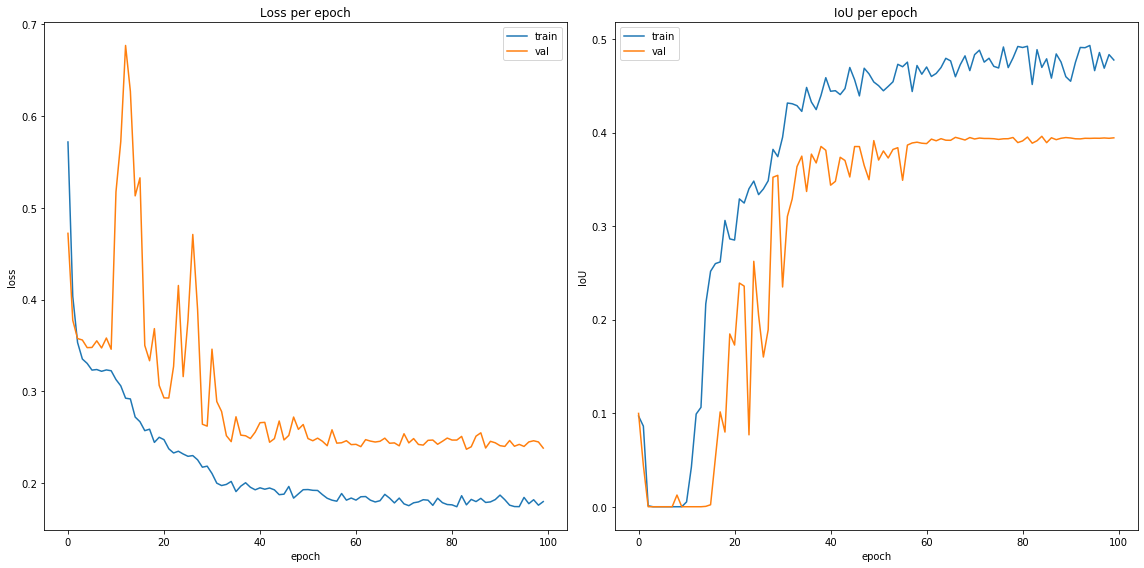

In [25]:
history = pd.DataFrame(hist.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].plot(history.index, history['loss'], label = "train")
ax[0].plot(history.index, history['val_loss'], label = "val")
ax[0].set_title('Loss per epoch')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history.index, history['iou_masked'], label = 'train')
ax[1].plot(history.index, history['val_iou_masked'], label = 'val')
ax[1].set_title('IoU per epoch')
ax[1].set_ylabel('IoU')
ax[1].set_xlabel('epoch')
ax[1].legend()

plt.tight_layout()

fig.show()

Save the demo model

In [26]:
os.makedirs(demo_configs['model_directory'], exist_ok=True)
with open(os.path.join(demo_configs['model_directory'], 'configs.json'), "w") as f:
    json.dump(demo_configs, f, indent=4)
model.save(os.path.join(demo_configs['model_directory'], 'model'))

INFO:tensorflow:Assets written to: demo_model/model/assets


The next cell runs a grid search over a few hyperparameter options. They are:

- Initial learning rate
- The number of filters in the last upsampling layer
- The threshold at which to predict that a given pixel has water

This took my workstation a couple hours to run. The next section begins by loading my best saved model, so it's not necessary to do the full sweep if you don't want to.

In [27]:
# Hyperparameter Sweep:

configs = {'model_directory' : 'best_model', 'output_channels' : 1}

os.makedirs(configs['model_directory'], exist_ok=True)

best_saved_iou = 0.

print("Running a grid search for best hyperparameters. This will take a while.")

for rate in tqdm.tqdm([.002, .001, .0005]):
    for size in [16, 32, 64]:
        
        # Build and train the model
        configs['learning_rate_base'] = rate
        configs['head_size'] = size
        
        with strategy.scope():
            model = build_model(configs)
            iou_metric = IoUMasked()

        callbacks = create_callbacks(configs)

        model.compile(optimizer='adam',
                      loss=BCE_masked_loss,
                      metrics=[iou_metric])
        
        hist = model.fit(x = train_dataset, 
                 epochs = 100, 
                 validation_data = val_dataset, 
                 verbose = 0,
                 callbacks = callbacks)
        
        # Do a detailed evaluation using different thresholds
        thresholds = [-5., -4., -3., -2., -1., 0., 1., 2., 3., 4., 5.]
        
        iou_mean,_ = run_detailed_evaluation(model, val_detail_dataset, thresholds = thresholds)
        
        # Get the threshold with the best performance
        thresh_best = max(iou_mean, key=iou_mean.get)
        iou_best = iou_mean[thresh_best]
        configs['threshold'] = thresh_best
        print("I just trained a model with Mean IoU %.3f on val dataset!" % iou_best)
        
        # If this is the best model so far, save it off.
        if iou_best > best_saved_iou:
            best_saved_iou = iou_best
            print("Found a new best model!")
            with open(os.path.join(configs['model_directory'], 'configs.json'), "w") as f:
                json.dump(configs, f, indent=4)
            model.save(os.path.join(configs['model_directory'], 'model'))
            
print("Finished the hyperparameter sweep!")

  0%|          | 0/3 [00:00<?, ?it/s]

Running a grid search for best hyperparameters. This will take a while.
INFO:tensorflow:batch_all_reduce: 17 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 17 all-reduces with algorithm = nccl, num_packs = 1
Now running detailed evaluation
I just trained a model with Mean IoU 0.335 on val dataset!
Found a new best model!
INFO:tensorflow:Assets written to: best_model/model/assets
INFO:tensorflow:batch_all_reduce: 17 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 17 all-reduces with algorithm = nccl, num_packs = 1
Now running detailed evaluation
I just trained a model with Mean IoU 0.334 on val dataset!
INFO:tensorflow:batch_all_reduce: 17 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 17 all-reduces with algorithm = nccl, num_packs = 1
Now running detailed evaluation


 33%|███▎      | 1/3 [30:41<1:01:22, 1841.07s/it]

I just trained a model with Mean IoU 0.333 on val dataset!
INFO:tensorflow:batch_all_reduce: 17 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 17 all-reduces with algorithm = nccl, num_packs = 1
Now running detailed evaluation
I just trained a model with Mean IoU 0.329 on val dataset!
Now running detailed evaluation
I just trained a model with Mean IoU 0.334 on val dataset!
Now running detailed evaluation


 67%|██████▋   | 2/3 [1:01:14<30:36, 1836.55s/it]

I just trained a model with Mean IoU 0.329 on val dataset!
Now running detailed evaluation
I just trained a model with Mean IoU 0.334 on val dataset!
Now running detailed evaluation
I just trained a model with Mean IoU 0.340 on val dataset!
Found a new best model!
INFO:tensorflow:Assets written to: best_model/model/assets
Now running detailed evaluation


100%|██████████| 3/3 [1:32:34<00:00, 1851.45s/it]

I just trained a model with Mean IoU 0.328 on val dataset!
Finished the hyperparameter sweep!


## Testing/Visualization/Interpretation

Begin by loading up the best saved model from my hyperparameter sweep.

In [28]:
# Load in the configurations
with open('best_model_for_loading/configs.json') as f:
    configs = json.load(f)
    
# Load best saved model (Ignore Warnings, we will compile afterwards)
with strategy.scope():
    model = tf.keras.models.load_model('best_model_for_loading/model', compile = False)
    model.compile(optimizer='adam',
              loss=BCE_masked_loss,
              metrics=[IoUMasked(configs['threshold'])])

print("Model successfully loaded")

Model successfully loaded


Load in the test dataset.

In [29]:
# The version where we forget about countries:
test_dataset = build_tf_dataset(test_df)
test_dataset = test_dataset.batch(BATCH_SIZE)

# The version where we pay attention to countries
test_detail_dataset = create_detailed_dataset(test_df, flip = False)

Do a detailed evaluation of the model's performance on the test dataset

In [30]:
_, iou = model.evaluate(test_dataset, verbose = False)
mean_iou_dict, per_country_iou_dict = run_detailed_evaluation(model, test_detail_dataset, thresholds = [configs['threshold']])

print('If we ignore countries, the model achieved %.3f iou across all the images' % iou)

for key in per_country_iou_dict[configs['threshold']]:
    print('%s got IoU %.3f'  %(key, per_country_iou_dict[configs['threshold']][key]))

Now running detailed evaluation
Per-country mean IoU is 0.473
If we ignore countries, the model achieved 0.445 iou across all the images
Bolivia got IoU 0.654
Ghana got IoU 0.535
India got IoU 0.609
Mekong got IoU 0.791
Nigeria got IoU 0.829
Pakistan got IoU 0.223
Paraguay got IoU 0.103
Somalia got IoU 0.058
Spain got IoU 0.545
Sri-Lanka got IoU 0.657
USA got IoU 0.199


One immediate observation is that the model's performance is inversely related to how dry a country is. This should be partly due to how IoU is computed. (For false positives, the IoU penalty per-pixel is higher in an area with little water).

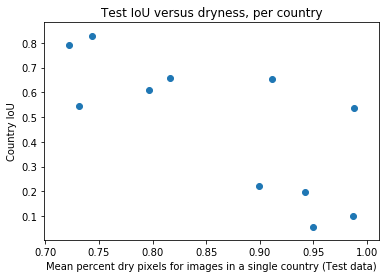

In [31]:
perc_dry_per_country = [test_df[test_df['country'] == country].mean()['perc_dry_known'] for country in countries_present]
test_iou_per_country = [per_country_iou_dict[configs['threshold']][country] for country in countries_present]

plt.scatter(perc_dry_per_country, test_iou_per_country)
plt.title("Test IoU versus dryness, per country")
plt.xlabel("Mean percent dry pixels for images in a single country (Test data)")
plt.ylabel("Country IoU")
plt.show()

Now we will visualize some individual images. First define a convenience function for visualization

In [32]:
def visualize_predictions(asset_id):
    color = "cyan"
    no_data_color = "magenta"
    alpha = 0.5
    
    raw = tf.expand_dims(create_example(asset_id), axis = 0)
    label = tf.expand_dims(create_label(asset_id), axis = 0)
    prediction = model.predict(raw)
    iou = IoUMasked(threshold = configs['threshold'])(label, prediction)

    raw = raw[0, :, :, :].numpy()
    label = label[0, : , :].numpy()
    prediction = prediction[0, :, :]

    f, axarr = plt.subplots(1, 3, figsize=(20, 10))

    axarr[0].imshow(raw)
    axarr[0].set_title("S1 image")

    axarr[1].imshow(raw)
    axarr[1].set_title("Ground Truth Labels")

    p = get_patchcollection_from_label(label, alpha=alpha, color=color)
    axarr[1].add_collection(p)
    p = get_patchcollection_from_label(label, -1, alpha=alpha, color=no_data_color)
    axarr[1].add_collection(p)

    axarr[2].imshow(prediction > configs['threshold'])

    axarr[2].set_title("Predicted Labels, %.3f IoU" % iou)
    plt.tight_layout()
    plt.show()

We want to record the model's performance on individual images in the test set.

In [33]:
test_ious = {asset : model.evaluate(tf.expand_dims(create_example(asset), axis = 0),
                            tf.expand_dims(create_label(asset), axis = 0),
                            verbose = False)[1] for asset in test_df.index}
test_ious_df = test_df.merge(pd.DataFrame.from_dict(test_ious, orient = 'index', columns = ['IoU']),
                              left_index = True, right_index = True).copy()
test_ious_df.sort_values('IoU')

perc_unknown  perc_water_known  perc_dry_known    country  \
Ghana_167233          0.000000          0.000000        1.000000      Ghana   
Ghana_7496            0.000000          0.000000        1.000000      Ghana   
Paraguay_40936        0.178577          0.000000        1.000000   Paraguay   
Somalia_61368         0.187588          0.000000        1.000000    Somalia   
Paraguay_224845       0.603577          0.000000        1.000000   Paraguay   
Mekong_221789         0.178593          0.000000        1.000000     Mekong   
Somalia_167787        0.158840          0.001020        0.998980    Somalia   
Nigeria_439488        0.125671          0.006405        0.993595    Nigeria   
India_59460           0.201382          0.001505        0.998495      India   
Paraguay_252217       0.024284          0.001173        0.998827   Paraguay   
USA_605492            0.000072          0.011563        0.988437        USA   
India_981708          0.145416          0.046370        0.953630      India   
USA_504150            0.000069          0.012444        0.987556        USA   
Pakistan_246510       0.012691          0.041500        0.958500   Pakistan   
USA_826217            0.000069          0.017160        0.982840        USA   
Paraguay_913449       0.000000          0.021046        0.978954   Paraguay   
Somalia_371421        0.118950          0.150146        0.849854    Somalia   
Paraguay_721886       0.000000          0.041710        0.958290   Paraguay   
USA_652955            0.000011          0.032528        0.967472        USA   
Spain_2938657         0.000267          0.037287        0.962713      Spain   
USA_831672            0.000107          0.079953        0.920047        USA   
Ghana_359826          0.000000          0.013336        0.986664      Ghana   
India_383430          0.041477          0.156118        0.843882      India   
Paraguay_149830       0.006500          0.007322        0.992678   Paraguay   
USA_770353            0.000011          0.131330        0.868670        USA   
USA_1068362           0.000076          0.118959        0.881041        USA   
Spain_1167260         0.000095          0.162213        0.837787      Spain   
India_570384          0.076843          0.060116        0.939884      India   
Pakistan_246718       0.102486          0.055789        0.944211   Pakistan   
Sri-Lanka_579082      0.205540          0.069460        0.930540  Sri-Lanka   
Paraguay_1019808      0.000000          0.019722        0.980278   Paraguay   
Sri-Lanka_849649      0.167606          0.008671        0.991329  Sri-Lanka   
Pakistan_1036366      0.578934          0.205409        0.794591   Pakistan   
India_103447          0.376041          0.164929        0.835071      India   
Bolivia_60373         0.240803          0.062708        0.937292    Bolivia   
Sri-Lanka_916628      0.008327          0.313601        0.686399  Sri-Lanka   
Sri-Lanka_847275      0.117428          0.218118        0.781882  Sri-Lanka   
Bolivia_294583        0.502289          0.115029        0.884971    Bolivia   
Sri-Lanka_713926      0.000153          0.307153        0.692847  Sri-Lanka   
India_900498          0.000580          0.473117        0.526883      India   
India_399883          0.000095          0.519962        0.480038      India   
Mekong_1396181        0.072792          0.596584        0.403416     Mekong   
Ghana_895194          0.036003          0.034415        0.965585      Ghana   
Spain_5650136         0.345413          0.607281        0.392719      Spain   
Nigeria_812045        0.095406          0.506541        0.493459    Nigeria   
Mekong_16233          0.000046          0.237327        0.762673     Mekong   

                                                           label_fp  \
Ghana_167233      c2s_data/v1.1/data/flood_events/HandLabeled/La...   
Ghana_7496        c2s_data/v1.1/data/flood_events/HandLabeled/La...   
Paraguay_40936    c2s_data/v1.1/data/flood_events/HandLabeled/La...   
Somalia_61368     c2

For fun, you can visualize on an arbitrary example:

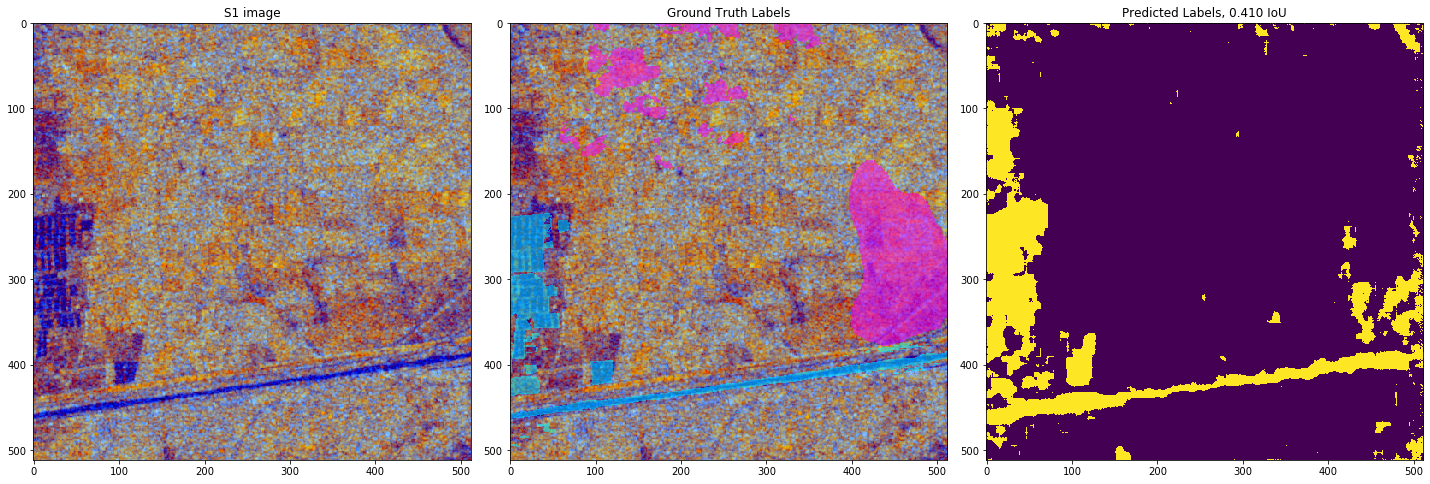

In [89]:
to_vis = 'Pakistan_246718'
visualize_predictions(to_vis)

__The Good (part 1):__ The model does well at identifying pixels which belong to a large body of water, especially when the border between water and land is very clear-cut

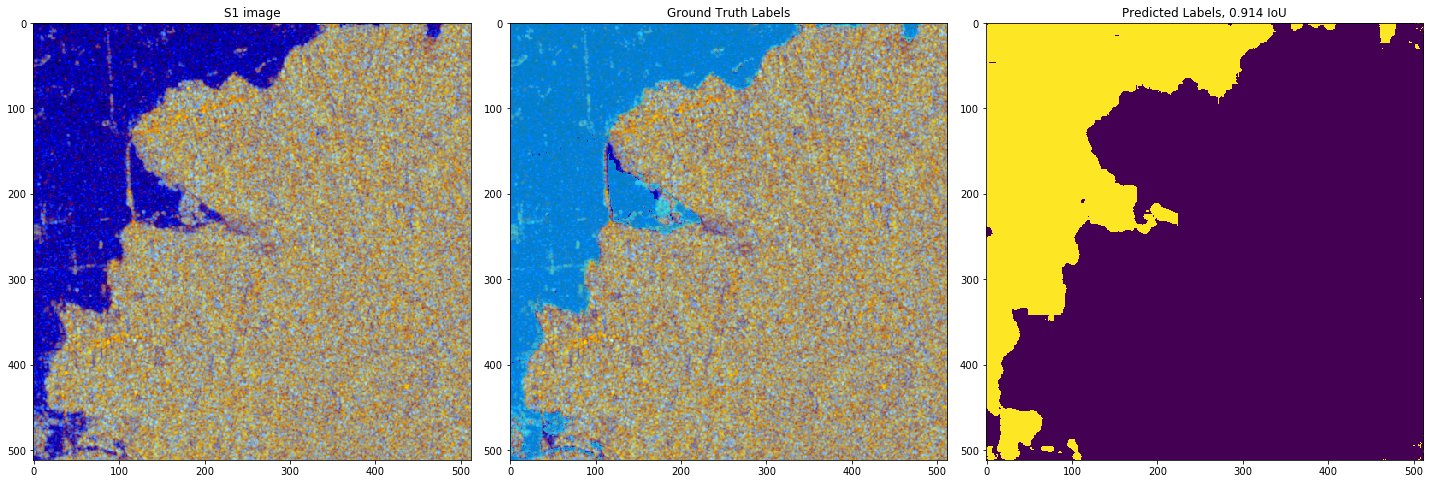

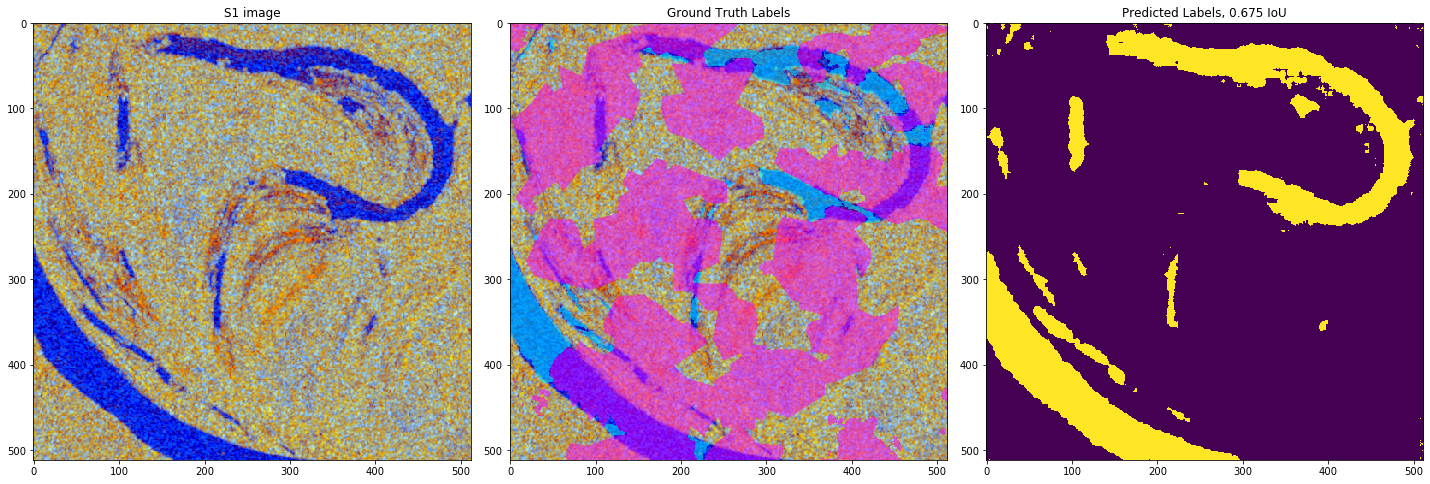

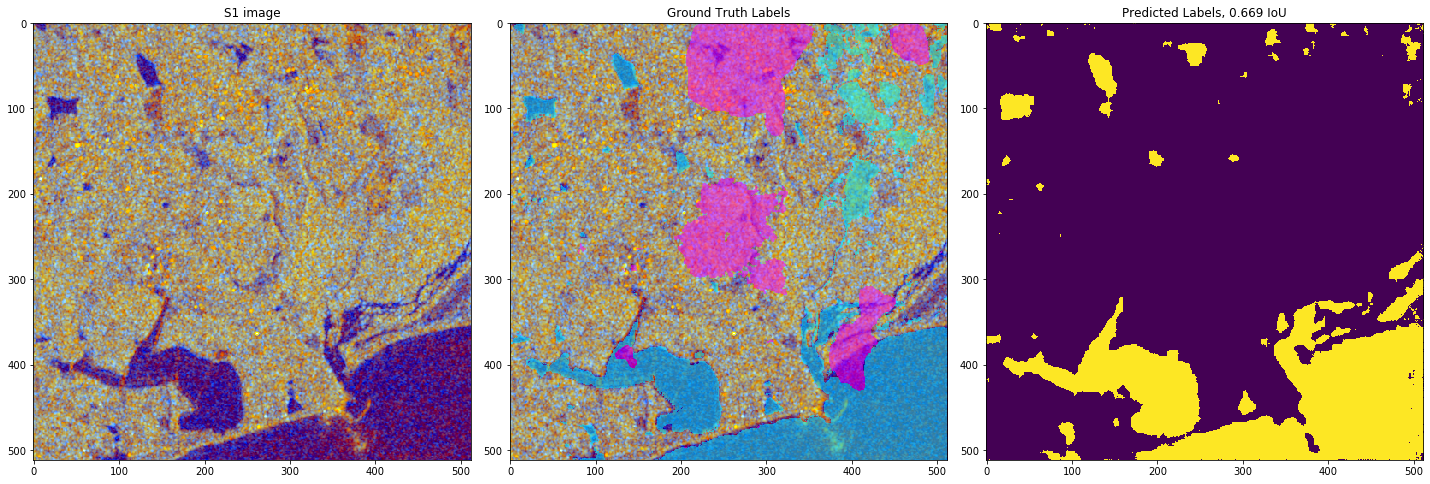

In [90]:
# Visualize Strength 1
visualize_predictions('Mekong_16233')
visualize_predictions('Bolivia_294583') 
visualize_predictions('Sri-Lanka_847275')

__The Good (part 2):__ In addition to dark blue, it seems that water has a second signature in these false color images, which is dark red. The model learned this as well, to an extent. Probably more data is required to learn this better.

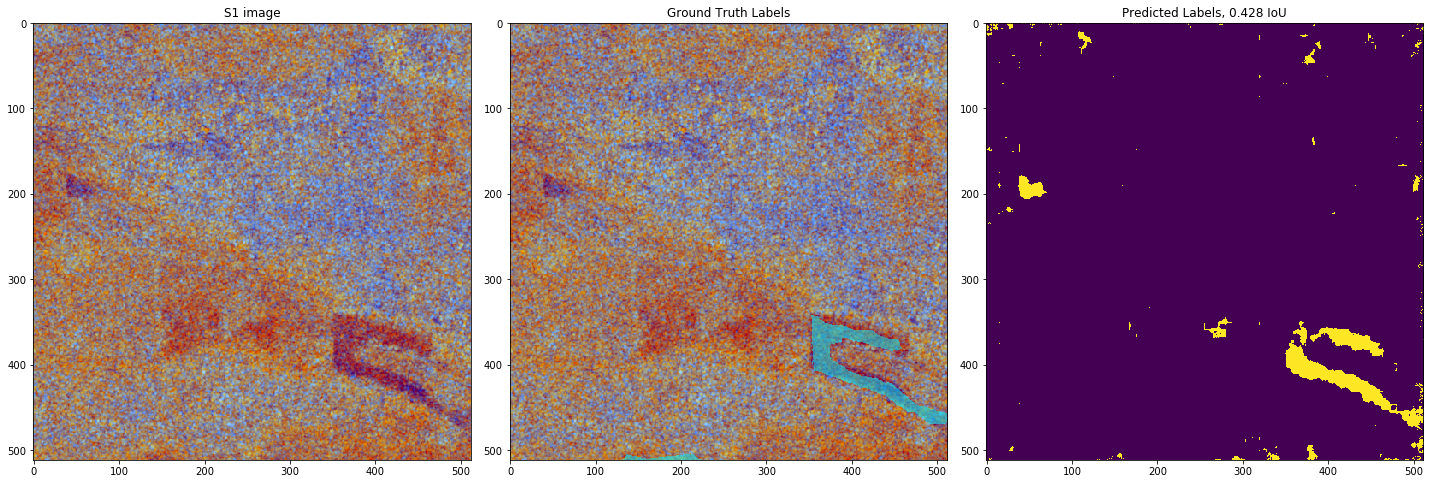

In [91]:
# Visualize Strength 2

visualize_predictions('Paraguay_1019808') 

__The Bad (part 1):__ The model doesn't do well with fine structure, either of water or of land. Also, notice there are some artifacts around the boundary of the model's predictions.

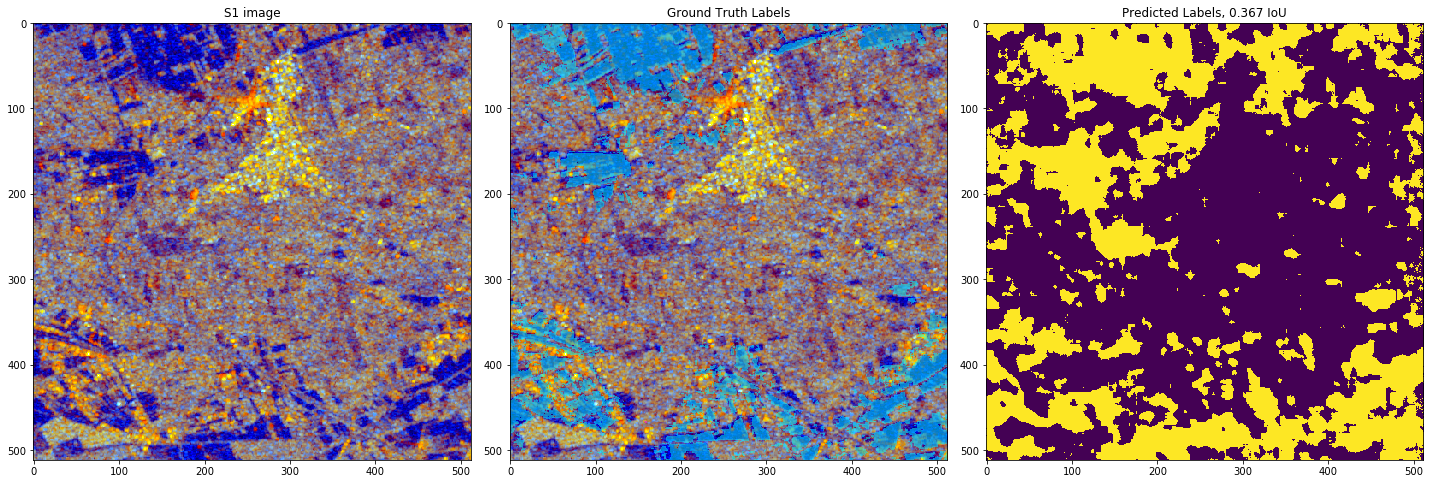

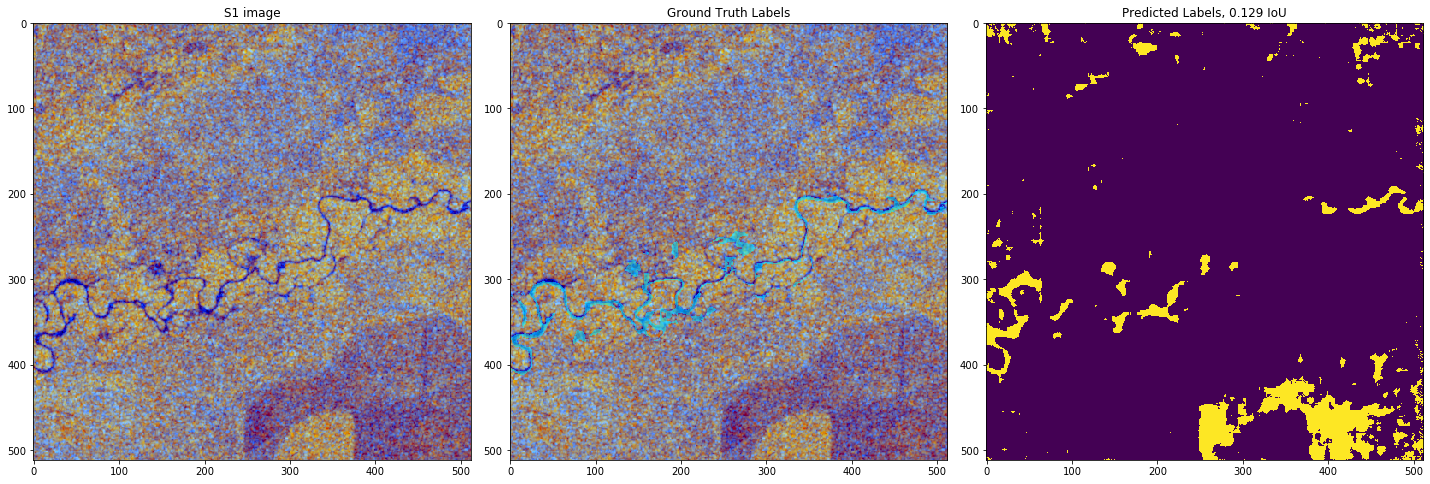

In [92]:
# Visualize Weakness 1
visualize_predictions('Spain_1167260') 
visualize_predictions('Paraguay_913449') 

__The Bad (part 2):__ The model gets fooled by pieces of the image that show up as (false color) dark blue. Here, I wonder if the dark blue swaths are the shadows of mountains.

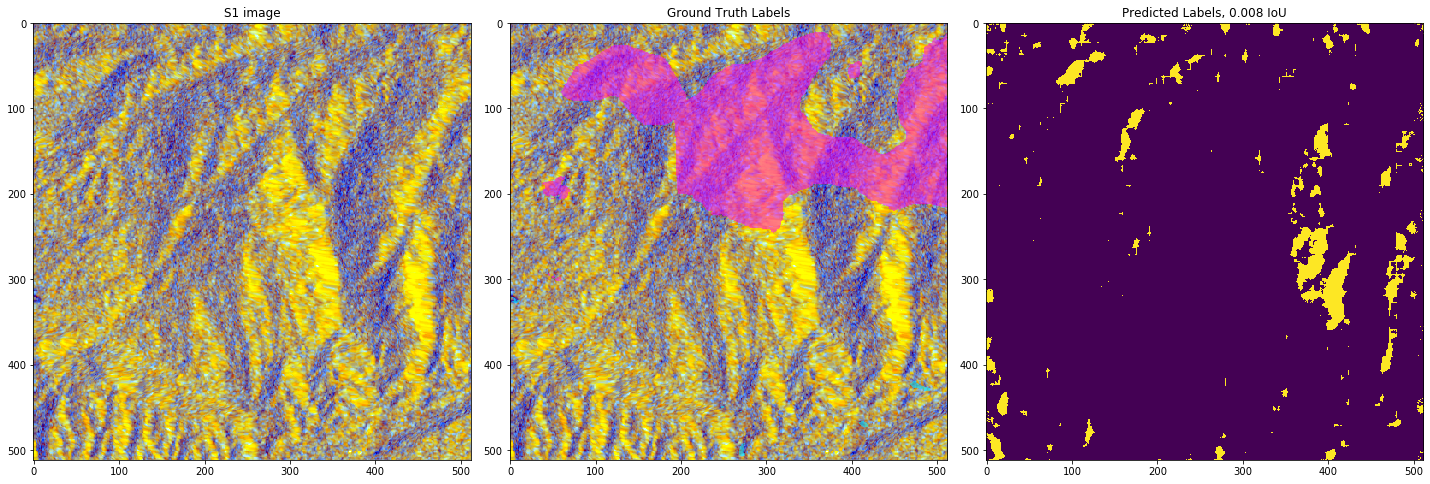

In [93]:
# Visualize Weakness 2
visualize_predictions('India_59460')

__Discussion: Next Steps__
- There are some standard improvements that should be added to what I did above.
    - I chose a ResNet-50 encoder somewhat at random, since I wasn't familiar with the problem or its typical data requirements. I would like to try larger and smaller architectures (eg ResNets, VGG-Nets, and others).
    - I would expand the hyperparameter sweep a bit. For instance, I didn't experiment with unfreezing the pre-trained weights of the feature extractor, and I didn't experiment with different optimizers. Loss weighting (see below) would be another hyperparameter.
    - I would introduce additional augmentations to reduce overfitting. For instance, I might begin with some color jitter and randomly removing ground truth labels.
- There are some problem-specific improvements I would make.
    - Mean IoU took a big hit because of the model's poor performance in dry countries (eg Somalia, Paraguay). One possible way to deal with this would be to introduce some weighting of the loss function, so that (for instance) false positives in dry images are penalized more.
    - It would be helpful to get more data for some of the countries (if I were working for Cloud to Street, for instance). On the other hand, if I were continuing with this particular problem setup, I might redesign my train/val/test splits to reduce the variance in the test and val datasets.
    - There are boundary artifacts. I expect that these could be either cut off by cropping the final image, or perhaps avoiding by padding out the original image, then cropping the model's predictions.
- There are some performance tweaks I would make.
    - In my particular hardware setup, I would have brought in mixed precision training (training at float16 goes faster).
    - After introducing other architecture, it would be helpful to form a Pareto curve to compare model speed with IoU.